In [246]:
import os
import pandas as pd
import re
from textblob import TextBlob
import sqlite3
import matplotlib
import matplotlib.pyplot as plt
matplotlib.font_manager._rebuild()
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', quality=100)

In [22]:
BASE_URL = 'dataset/'

master_array = []

for filename in os.listdir(BASE_URL):
    
    f = open(BASE_URL+filename, "r", encoding='utf-8')
    
    split_name = filename.split('.') #obtain the season and episodes
    season = split_name[0]   
    episode = split_name[1]
    
    script = f.read() #read the script file
    pattern = re.compile(r'\s(?=\w+(?=:))') # store the regex
    result = re.split(pattern, script) # split the script where our pattern matched (pink dot)
    
    for item in result:
        split_line = item.split(':')
        try:
            character = split_line[0]
            speech = split_line[1]
            master_array.append([season, episode, character, speech])
        except:
            pass

In [23]:
df = pd.DataFrame(master_array, columns=['season', 'episode', 'char', 'line'])
df

,season,episode,char,line
0,1,1,by,Marta Kauffman & David Crane\nTranscribed
1,1,1,by,guineapig\nAdditional transcribing
2,1,1,by,Eric Aasen\n(Note
3,1,1,Monica,There's nothing to tell! He's just some guy\n...
4,1,1,Joey,"C'mon, you're going out with the guy! There's..."
...,...,...,...,...
61845,9,9,Scene,Central Perk.� Phoebe and Mike are on the sof...
61846,9,9,ROSS,Hey you guys.� (He sits.)
61847,9,9,MIKE,Hey.
61848,9,9,PHOEBE,Hey.� I'll be right back.� I've got to go to ...


#### Droping all of these rows by removing the character 'by'

In [24]:
df = df[df.char != 'by']
df

,season,episode,char,line
3,1,1,Monica,There's nothing to tell! He's just some guy\n...
4,1,1,Joey,"C'mon, you're going out with the guy! There's..."
5,1,1,Chandler,"All right Joey, be\nnice. So does he have a ..."
6,1,1,Phoebe,"Wait, does he eat chalk?\n(They all stare, be..."
7,1,1,Phoebe,"Just, 'cause, I don't want her to go through\..."
...,...,...,...,...
61845,9,9,Scene,Central Perk.� Phoebe and Mike are on the sof...
61846,9,9,ROSS,Hey you guys.� (He sits.)
61847,9,9,MIKE,Hey.
61848,9,9,PHOEBE,Hey.� I'll be right back.� I've got to go to ...


In [25]:
df['char'].unique()

array(['Monica', 'Joey', 'Chandler', 'Phoebe', 'All', 'Ross', '3',
       'Rachel', 'Waitress', 'me', 'Paul', '6', 'TV', 'Frannie',
       'Customer', 'holiday', 'Max', 'David', 'Janice', 'Sandy', 'Bobby',
       'Clark', 'Street', 'Guy', 'Leno', 'Paolo', 'Bing', 'Carol',
       'Susan', 'Assistant', '4', '5', 'continues', 'Guys', 'Girls', '2',
       'Roger', 'Tribbiani', 'Ronni', 'stop', 'Woman', 'Lorraine',
       'Kristin', '1', 'something', 'Tedlock', 'Celia', 'Steve', 'Ursula',
       'Teacher', 'Helen', 'Nina', 'Douglas', 'Jamie', 'Fran', 'voice',
       '13', 'tip', 'Nurse', 'Mitchell', 'Rosen', 'Party', 'Friends',
       'Geller', 'Iris', 'Note', 'have', 'Heckles', 'Intercom', 'Luisa',
       'Both', 'Barry', 'advice', 'Marsha', 'Robbie', 'Bernice',
       'Oberman', 'Mindy', 'letters', 'this', 'Danielle', 'Baldhara',
       'PA', 'Actor', 'Ethan', 'thinking', 'Gerston', 'Santos', 'Petrie',
       'Franzblau', 'Lydia', 'Janitor', 'Melanie', 'Attendant', 'Man',
       'Carl', '

In [26]:
df['char'].replace({'Chandler':'Chandler','CHANDLER':'Chandler', 'Chandlers':'Chandler', 'chandler': 'Chandler',
                    'Joey':'Joey', 'JOEY': 'Joey',
                    'Monica':'Monica','MONICA':'Monica', 'MOnica': 'Monica', 'MNCA': 'Monica',
                    'Phoebe':'Phoebe','PHOEBE':'Phoebe', 'Pheebs':'Phoebe', 'Pheebs':'Phoebe',
                    'Rachel':'Rachel','RACHEL':'Rachel', 'RACH':'Rachel', 'RAHCEL':'Rachel', 'Racel':'Rachel', 'Rache':'Rachel',
                    'Ross':'Ross', 'RUSS':'Ross', 'ROSS': 'Ross'}, inplace=True)

C:\Users\shadow\Anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [27]:
char = ['Chandler', 'Joey', 'Monica', 'Phoebe', 'Rachel', 'Ross']
df = df[df['char'].isin(char)]

In [28]:
df

,season,episode,char,line
3,1,1,Monica,There's nothing to tell! He's just some guy\n...
4,1,1,Joey,"C'mon, you're going out with the guy! There's..."
5,1,1,Chandler,"All right Joey, be\nnice. So does he have a ..."
6,1,1,Phoebe,"Wait, does he eat chalk?\n(They all stare, be..."
7,1,1,Phoebe,"Just, 'cause, I don't want her to go through\..."
...,...,...,...,...
61842,9,9,Ross,"(holds up the message) Uh, Rach."
61843,9,9,Rachel,(still looking at Emma) Yeah?
61844,9,9,Ross,"(pauses, then crunches up the note and stuffs..."
61846,9,9,Ross,Hey you guys.� (He sits.)


In [29]:
df['sentiment'] = df['line'].apply(lambda x: TextBlob(x).sentiment[0])

C:\Users\shadow\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
df['season'] = df['season'].apply(lambda x: int(x))
df['episode'] = df['episode'].apply(lambda x: int(x))

C:\Users\shadow\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\shadow\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50925 entries, 3 to 61848
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   season     50925 non-null  int64  
 1   episode    50925 non-null  int64  
 2   char       50925 non-null  object 
 3   line       50925 non-null  object 
 4   sentiment  50925 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.3+ MB


In [9]:
conn = sqlite3.connect('friends_script.db') #connect to the database
cur = conn.cursor()
cur.execute('CREATE TABLE Friends (season number, episode number, char text, line text, sentiment integer)')
conn.commit()

In [33]:
df.to_sql('Friends', conn, if_exists='replace', index=False) # save into the 'lines' table

## The Most Popular Friend

In [163]:
cur.execute("SELECT char, COUNT(line) AS 'spoken_lines' FROM Friends GROUP BY char ORDER BY spoken_lines DESC")
most_lines = [c for c in cur.fetchall()]

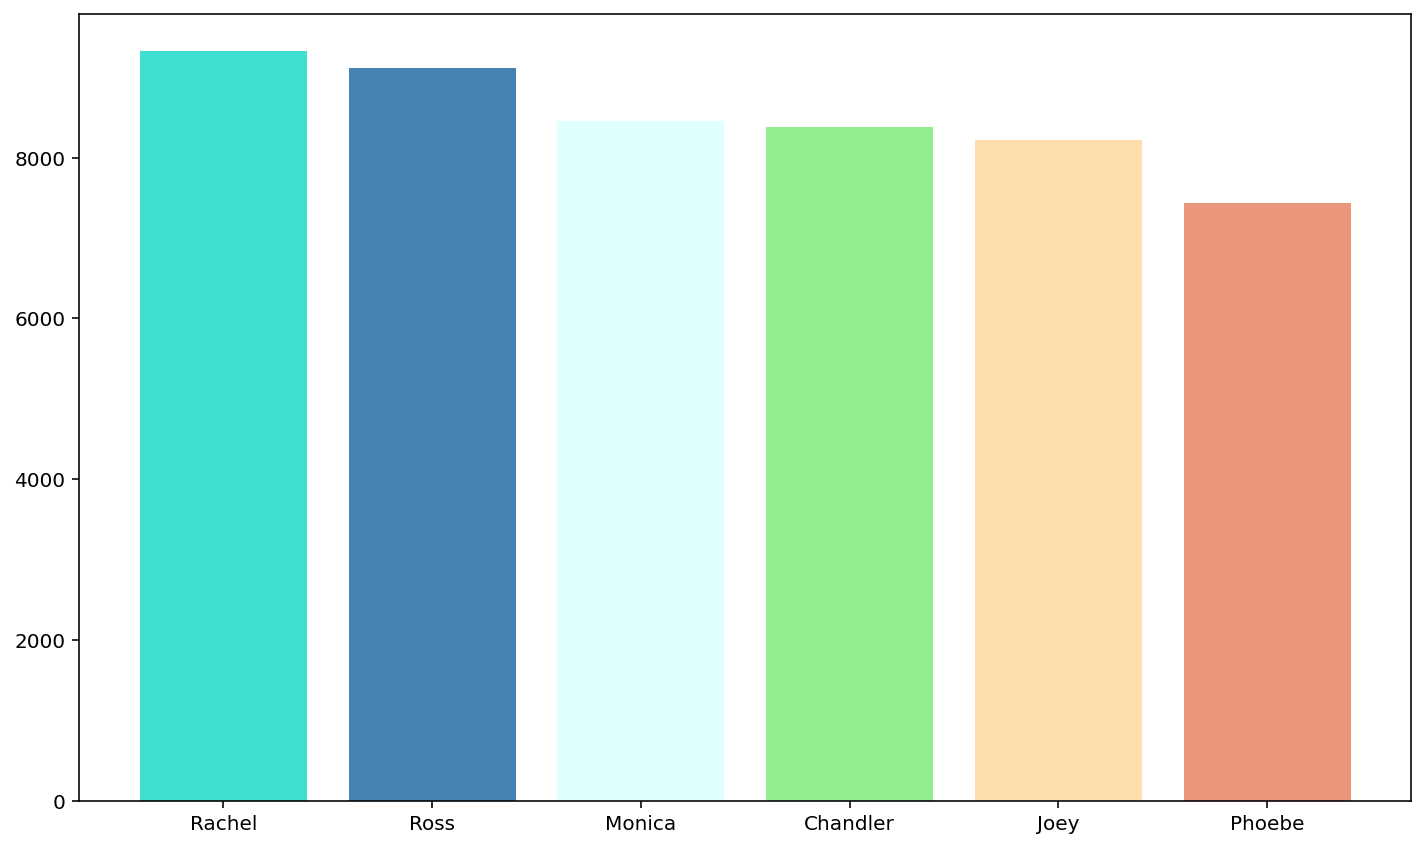

In [164]:
plt.rc('font', family='Open Sans')
plt.rcParams['figure.figsize'] = (10, 6)
fig, ax = plt.subplots()
plt.bar(
    x=[line[0] for line in most_lines],
    height=[line[1] for line in most_lines],
    color=['#40E0D0', '#4682B4', '#E0FFFF', '#90EE90', '#FFDEAD', '#E9967A']
)
fig.tight_layout()

## Number of lines per season

In [71]:
cur.execute("SELECT char, season, count(line) AS total_lines FROM Friends WHERE char IN ('Rachel', 'Ross', 'Monica','Chandler','Joey', 'Phoebe') GROUP BY season, char")
lines_per_season = [c for c in cur.fetchall()]

In [73]:
lines_dict = {}
for lines in lines_per_season:
    char = lines[0]
    season = lines[1]
    total_lines = lines[2]
    
    if char in lines_dict:
        # append the new number to the existing array at this slot
        lines_dict[char][season] = total_lines
    else:
        # create a new array in this slot
        lines_dict[char] = {
            season: total_lines
        }

In [75]:
lines_dict['Chandler']

{1: 824,
 2: 690,
 3: 827,
 4: 915,
 5: 942,
 6: 1039,
 7: 850,
 8: 676,
 9: 929,
 10: 692}

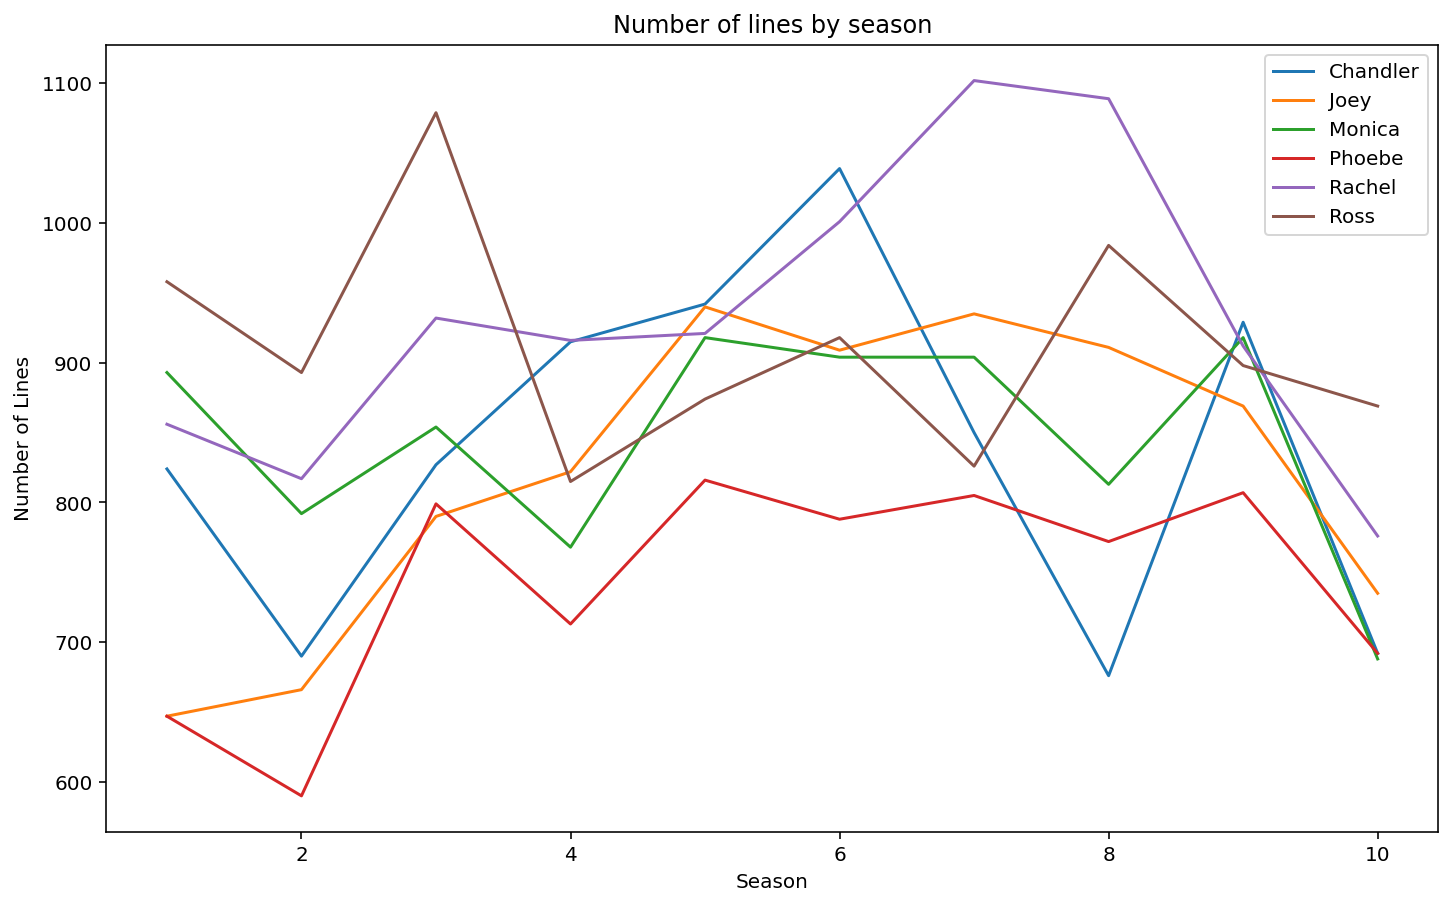

In [153]:
fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = (10, 6)
for char in lines_dict.keys():
    x1 = lines_dict[char].keys()
    y1 = lines_dict[char].values()
    plt.plot(x1, y1, label = char)
    
fig.tight_layout()
plt.xlabel('Season')
plt.ylabel('Number of Lines')
plt.title('Number of lines by season')
plt.legend()
plt.show()

### Most Spoken About


In [129]:
nicknames = [['Rachel', 'Rach'], 
             ['Ross', 'Ross-A-Tron', 'Professor Geller'], 
             ['Monica', 'Mon'],
             ['Chandler', 'Chan'],
             ['Joey', 'Joe'], 
             ['Phoebe', 'Phoebes']]

In [130]:
all_lines = pd.read_sql("SELECT line FROM Friends", conn)
all_lines

,line
0,There's nothing to tell! He's just some guy\n...
1,"C'mon, you're going out with the guy! There's..."
2,"All right Joey, be\nnice. So does he have a ..."
3,"Wait, does he eat chalk?\n(They all stare, be..."
4,"Just, 'cause, I don't want her to go through\..."
...,...
50920,"(holds up the message) Uh, Rach."
50921,(still looking at Emma) Yeah?
50922,"(pauses, then crunches up the note and stuffs..."
50923,Hey you guys.� (He sits.)


In [131]:
char_mention = [] 


for name_list in nicknames:    # loop for each character
    mention_counter = 0        # keep track of the mentions
    for name in name_list:     # loop for each nickname
        mentions = all_lines['line'].str.count(name).sum()
        mention_counter += mentions
    char_mention.append([name_list[0], mention_counter]) #append the name and mention count

In [138]:
char_mention = sorted(char_mention, key=lambda x: x[1], reverse=True)
char_mention

[['Joey', 5815],
 ['Chandler', 5233],
 ['Rachel', 5095],
 ['Monica', 4967],
 ['Ross', 3058],
 ['Phoebe', 1827]]

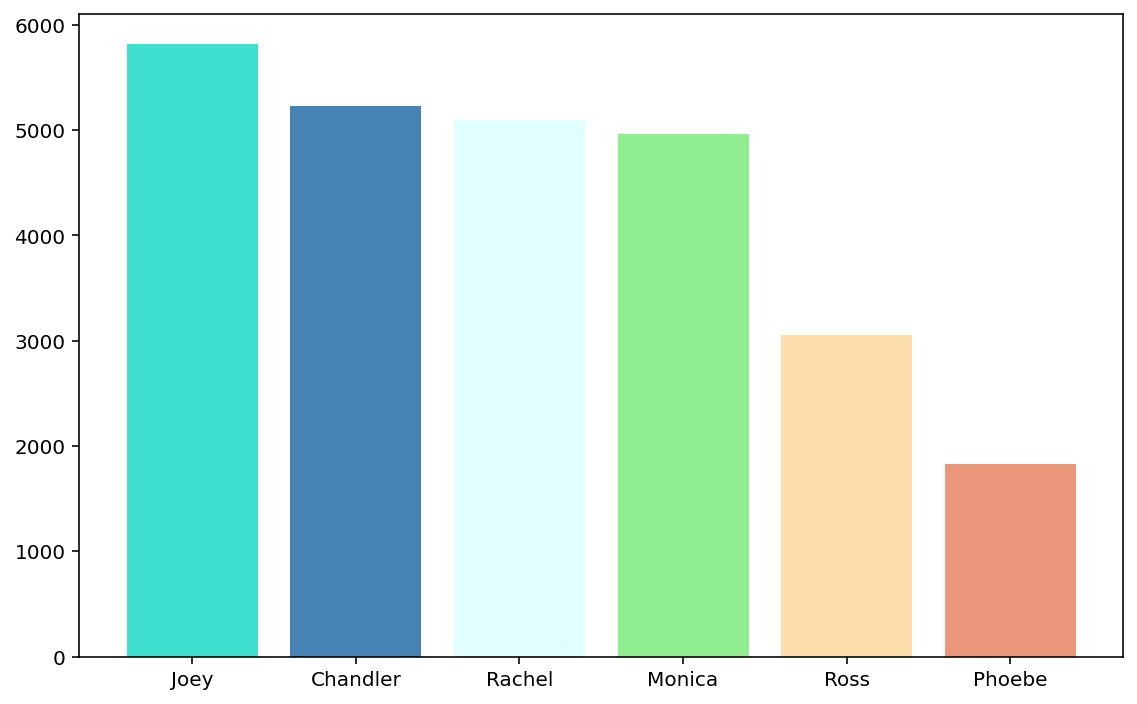

In [154]:
plt.rc('font', family='Open Sans')
plt.rcParams['figure.figsize'] = (8, 5)
fig, ax = plt.subplots()
plt.bar(
    x=[mention[0] for mention in char_mention],
    height=[mention[1] for mention in char_mention],
    color=['#40E0D0', '#4682B4', '#E0FFFF', '#90EE90', '#FFDEAD', '#E9967A']
)
fig.tight_layout()

### Largest Vocabulary

In [247]:
# function to remove all non alphabetical characters keep spaces
def alphanumonly(text):
    '''Remove all non letters from string'''
    regex = re.compile('[^a-zA-Z ]')
    #First parameter is the replacement, second parameter is your input string
    return(regex.sub('', text))

In [234]:
cur.execute("SELECT char, line FROM Friends WHERE char IN ('Rachel', 'Ross', 'Monica','Chandler','Joey', 'Phoebe')")
lines_per_season = [c for c in cur.fetchall()]

In [256]:
monica_vocab = set()
chandler_vocab = set()
ross_vocab = set()
phoebe_vocab = set()
rachel_vocab = set()
joey_vocab = set()

for lines in lines_per_season:
    char = lines[0]
    split_words = lines[1].split(' ')
    for words in split_words:
        alphabetical = alphanumonly(words)
        if char == 'Monica':
            monica_vocab.add(alphabetical)
            
        if char == 'Joey':
            joey_vocab.add(alphabetical)
        
        if char == 'Ross':
            ross_vocab.add(alphabetical)
        
        if char == 'Phoebe':
            phoebe_vocab.add(alphabetical)
        
        if char == 'Chandler':
            chandler_vocab.add(alphabetical)
        
        if char == 'Rachel':
            rachel_vocab.add(alphabetical)

In [257]:
len(joey_vocab)

11489

In [258]:
joey_vocab

{'',
 'winnerTime',
 'anythingThe',
 'donefor',
 'pack',
 'stunnedCommercial',
 'Heh',
 'otherpuppies',
 'Know',
 'lie',
 'robotPhoebes',
 'These',
 'wearingChandler',
 'disgustedly',
 'expects',
 'Jeannie',
 'Paolo',
 'startlesJoey',
 'closer',
 'RACH',
 'dreamtabout',
 'hangThe',
 'ax',
 'frowning',
 'Broadway',
 'Knowing',
 'firstborn',
 'religious',
 'ahhsThe',
 'stepity',
 'exit',
 'pleasure',
 'gods',
 'Shutter',
 'thegang',
 'bunch',
 'piano',
 'wasbehind',
 'lid',
 'meat',
 'credit',
 'isnt',
 'Chandlerfollows',
 'friends',
 'Holds',
 'botheringScene',
 'shown',
 'rightacross',
 'spadesOh',
 'MaMr',
 'flipflopJoey',
 'hertonight',
 'getdown',
 'hard',
 'excitement',
 'RachHe',
 'Hombre',
 'goodtooA',
 'soglad',
 'Archie',
 'pan',
 'patient',
 'hearing',
 'blooCasting',
 'okayhey',
 'removesthe',
 'Dude',
 'Falls',
 'memoriesWhoa',
 'anywhereTheres',
 'tooGIRL',
 'doinPhoebe',
 'outbid',
 'thoseguys',
 'Funny',
 'alarm',
 'alrightCharlie',
 'actally',
 'stuffaround',
 'robots',
